In [11]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
import matplotlib.pyplot as plt
import math
from inspect import isfunction
from functools import partial
from tqdm import tqdm, trange
from einops import rearrange

import sys, os
sys.path.append("../") # important for relative imports to work

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from utils.datamodule import CIFAR10Datamodule, MNISTDatamodule, AnimeDataModule
import numpy as np
from utils.tools import get_arrs, timestep_to_tensor, show_tensor

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

train_dm = AnimeDataModule("data/anime_faces",batch_size=32, train = True)
val_dm = AnimeDataModule("data/anime_faces",batch_size=32, train = False)

from models.unet import KarrasUNet
import numpy as np
# Load model
model = torch.load("../saved_models/ddpm_anime_quadratic_schedule_20_epochs.pth")

model = model.to(device)
# Multi GPU training
# model = nn.DataParallel(model, device_ids=[2, 3])
im = next(iter(train_dm.dataloader))[0][:1].to(device)

epsilon_theta = model(im, timestep_to_tensor(0, device = device))
assert epsilon_theta.shape == im.shape

from train.beta_schedules import *
# MAKE SURE YOU'RE USING THE SAME SCHEDULE AS THE ONE USED FOR TRAINING
FORWARD_STEPS = 1000
scheduler_dict = get_arrs(quadratic_beta_schedule, device, forward_steps=FORWARD_STEPS)

### Show image grid:

100%|██████████| 200/200 [00:19<00:00, 10.15it/s]


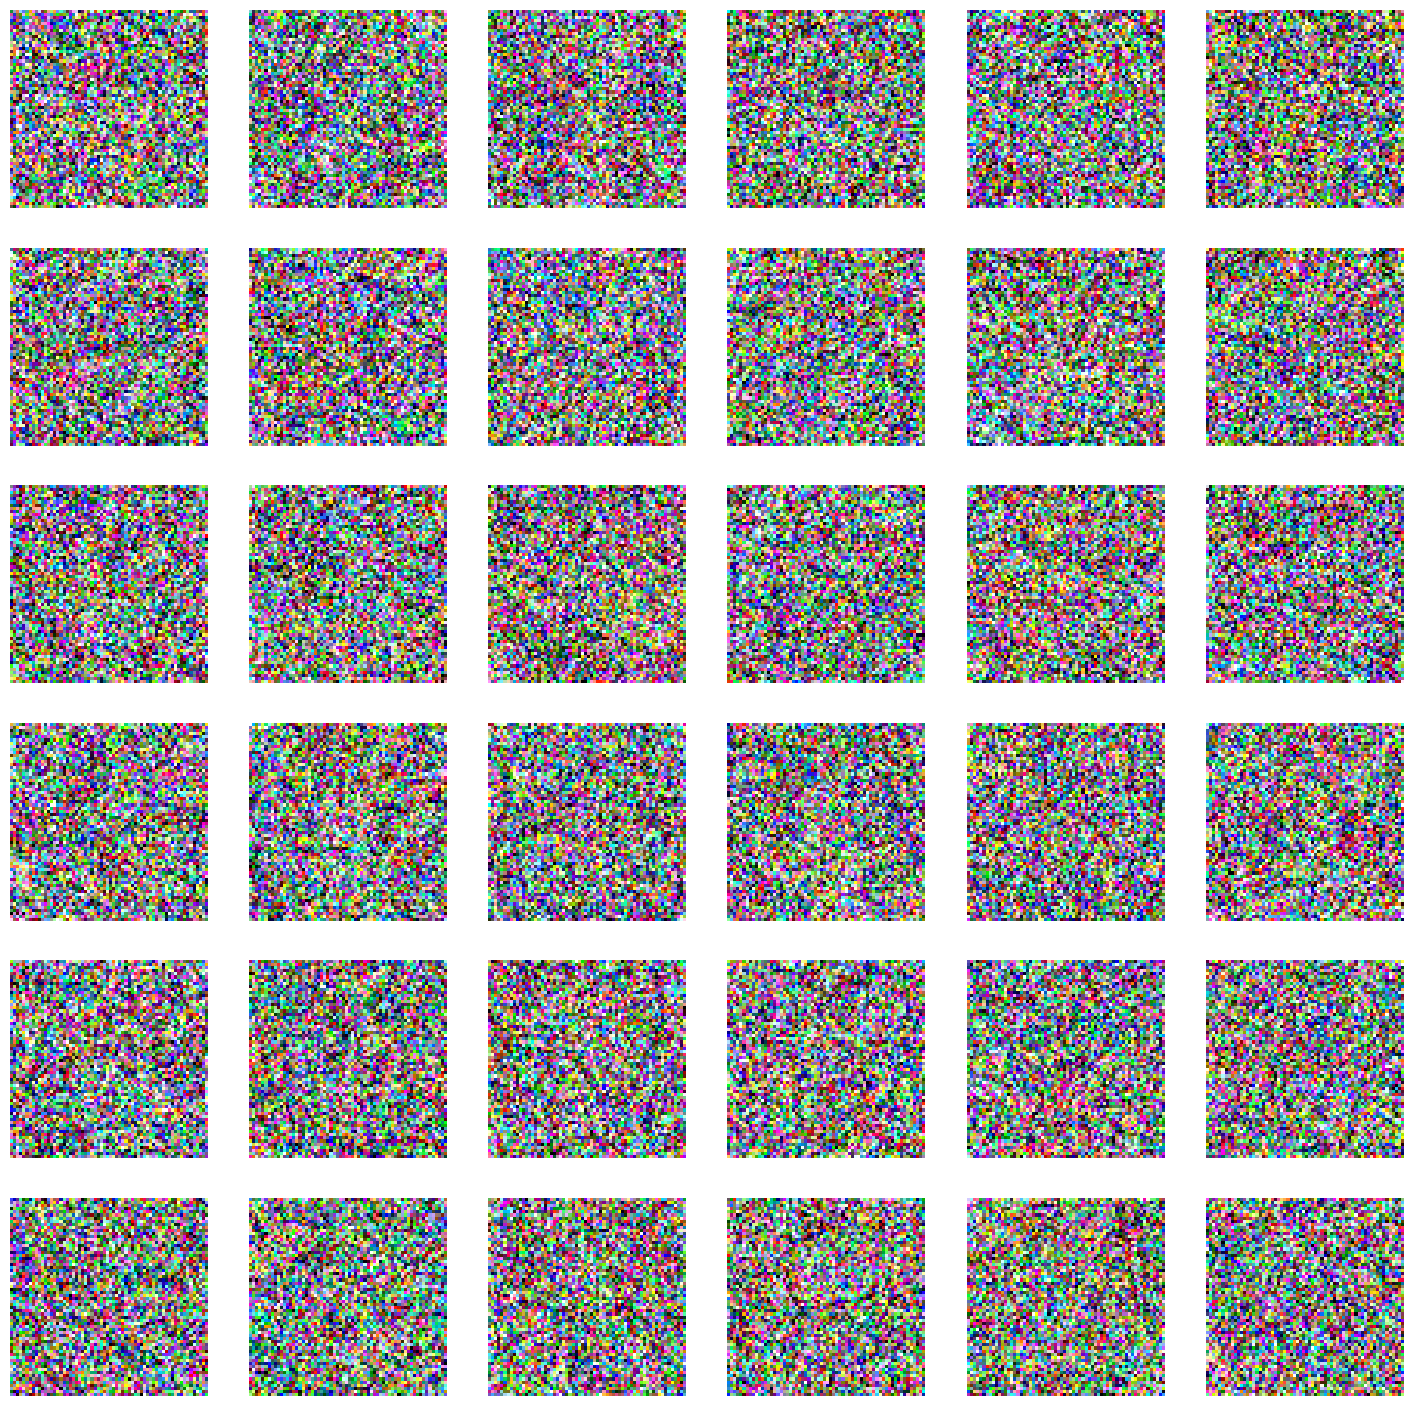

In [16]:
from train.diffusion_process import DDPM_denoising_process, DDIM_denoising_process

def visualize_output_grid(scheduler_dict, model, shape, forward_steps = 1000, rows = 5, cols = 5,
                          display_size = 3,
                          device = None):
    fig, ax = plt.subplots(rows, cols, figsize=(rows * display_size, cols * display_size), squeeze = False)
    assert len(shape) == 3, "Expected shape (channels, height, width)"
    HEIGHT, WIDTH, CHANNELS = shape
    ims = DDIM_denoising_process((rows * cols, HEIGHT, WIDTH, CHANNELS), scheduler_dict = scheduler_dict,
                                 forward_steps = forward_steps,
                                 backward_steps = 200,
                                 device = device, model = model)
    # ims: (steps, batch_size, channels, height, width)
    ims = ims[-1]
    for i in range(rows):
        for j in range(cols):
            ax[i, j].imshow(show_tensor(ims[i * cols + j]))
            ax[i, j].axis('off')
    plt.show()
    return ims

ims = visualize_output_grid(scheduler_dict, model, (3, 64, 64), forward_steps = 1000, rows = 6, cols = 6, device = device)

## DDIMs

### Visualize DDIM sampling:

100%|██████████| 4/4 [00:00<00:00, 44.44it/s]


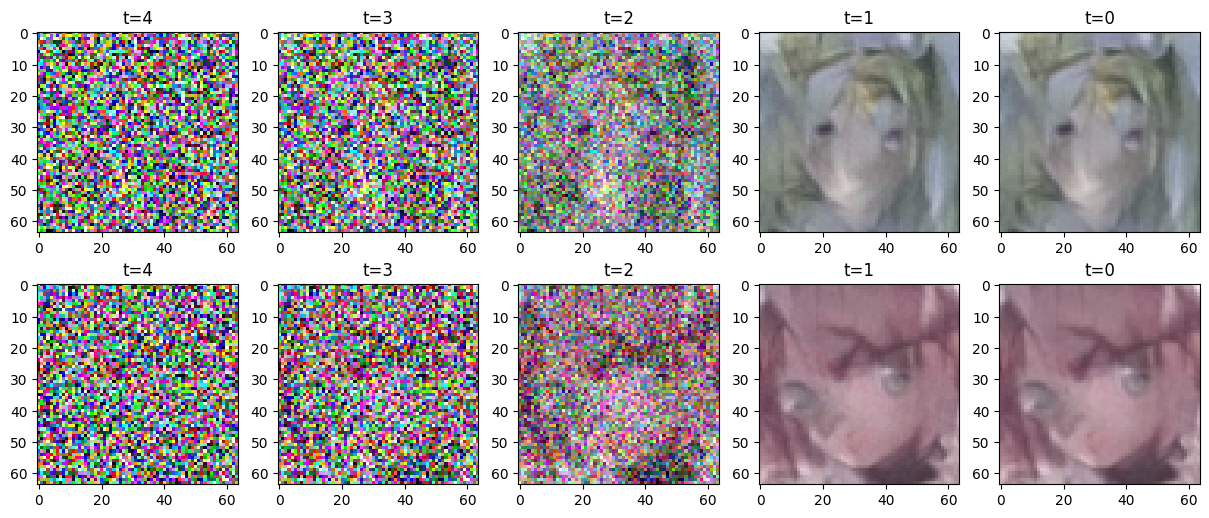

In [44]:
from train.vis_utils import visualize_DDIM_denoising
samples = visualize_DDIM_denoising(scheduler_dict, model, (3, 64, 64), forward_steps = 1000, backward_steps = 4, steps_to_show = 4,
                         rows_to_show= 2, device = device)

100%|██████████| 1000/1000 [00:29<00:00, 33.61it/s]


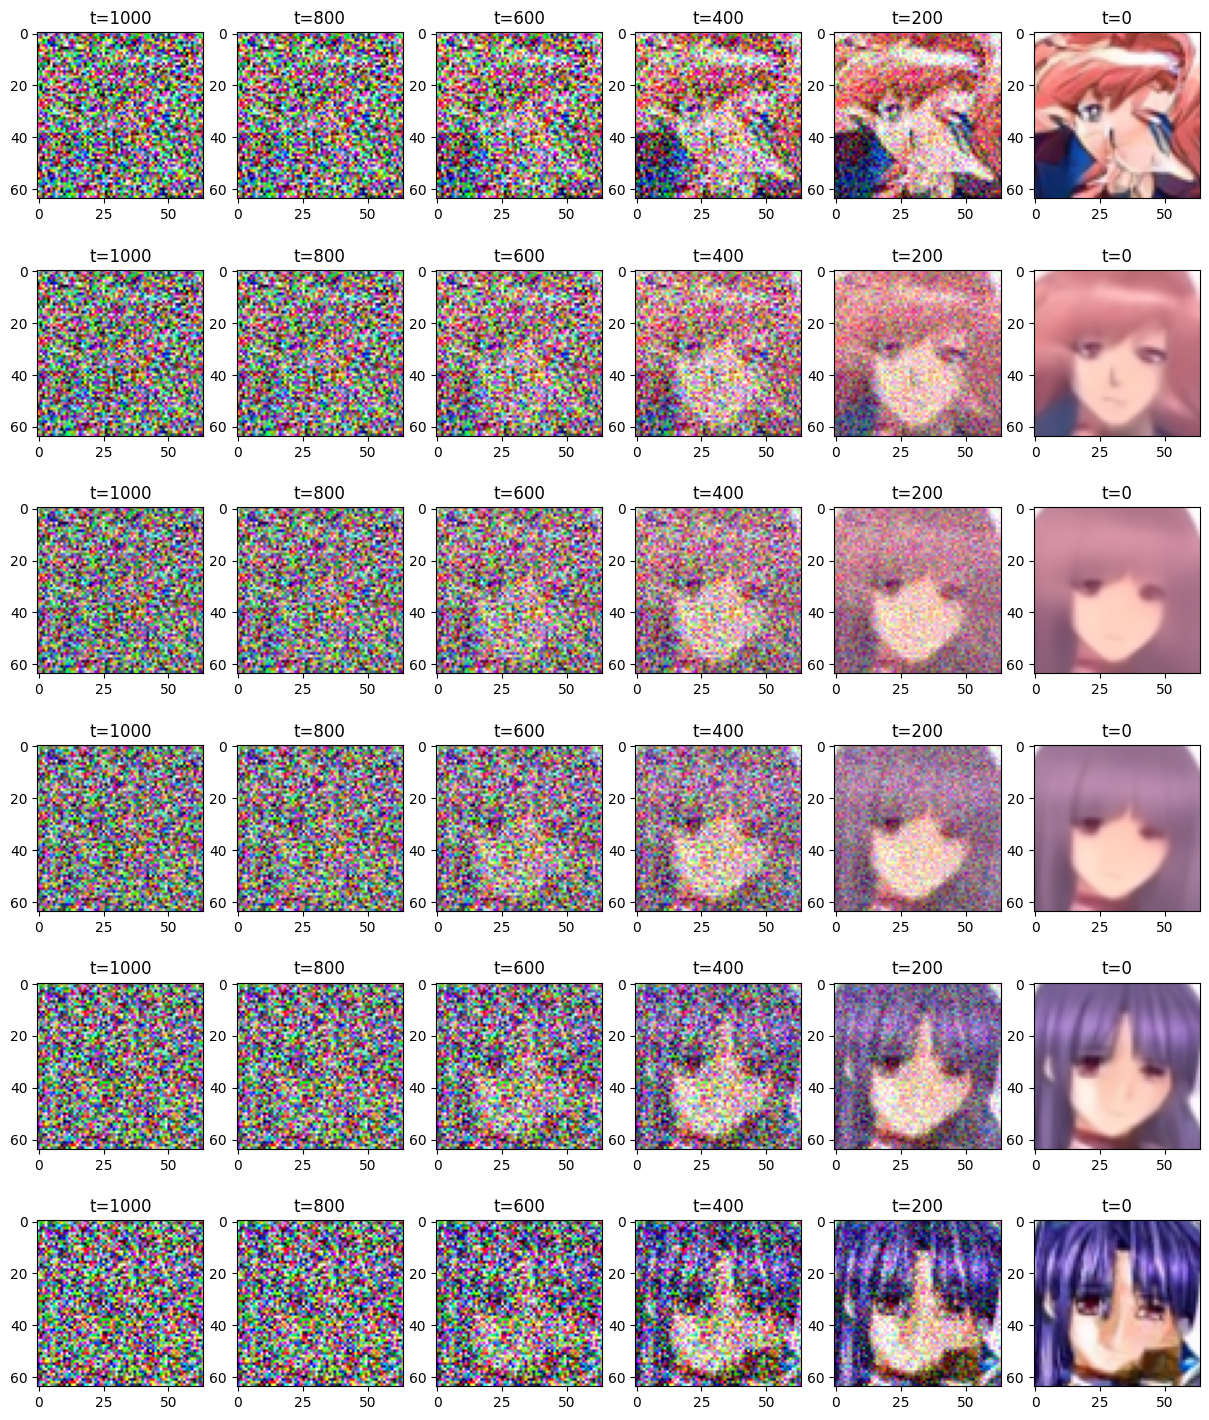

In [30]:
# Interpolating
noise1 = torch.randn(1, 3, 64, 64).to(device)
noise2 = torch.randn(1, 3, 64, 64).to(device)
interpolated_noises = [noise1 * (1 - i) + noise2 * i for i in np.linspace(0, 1, 6)]
interpolated_noises = torch.cat(interpolated_noises, dim = 0)
interpolated_samples = visualize_DDIM_denoising(scheduler_dict, model, (3, 64, 64), forward_steps = 1000, backward_steps = 1000, steps_to_show = 5,
                         rows_to_show= len(interpolated_noises), device = device, noise = interpolated_noises)

100%|██████████| 1000/1000 [00:29<00:00, 33.77it/s]


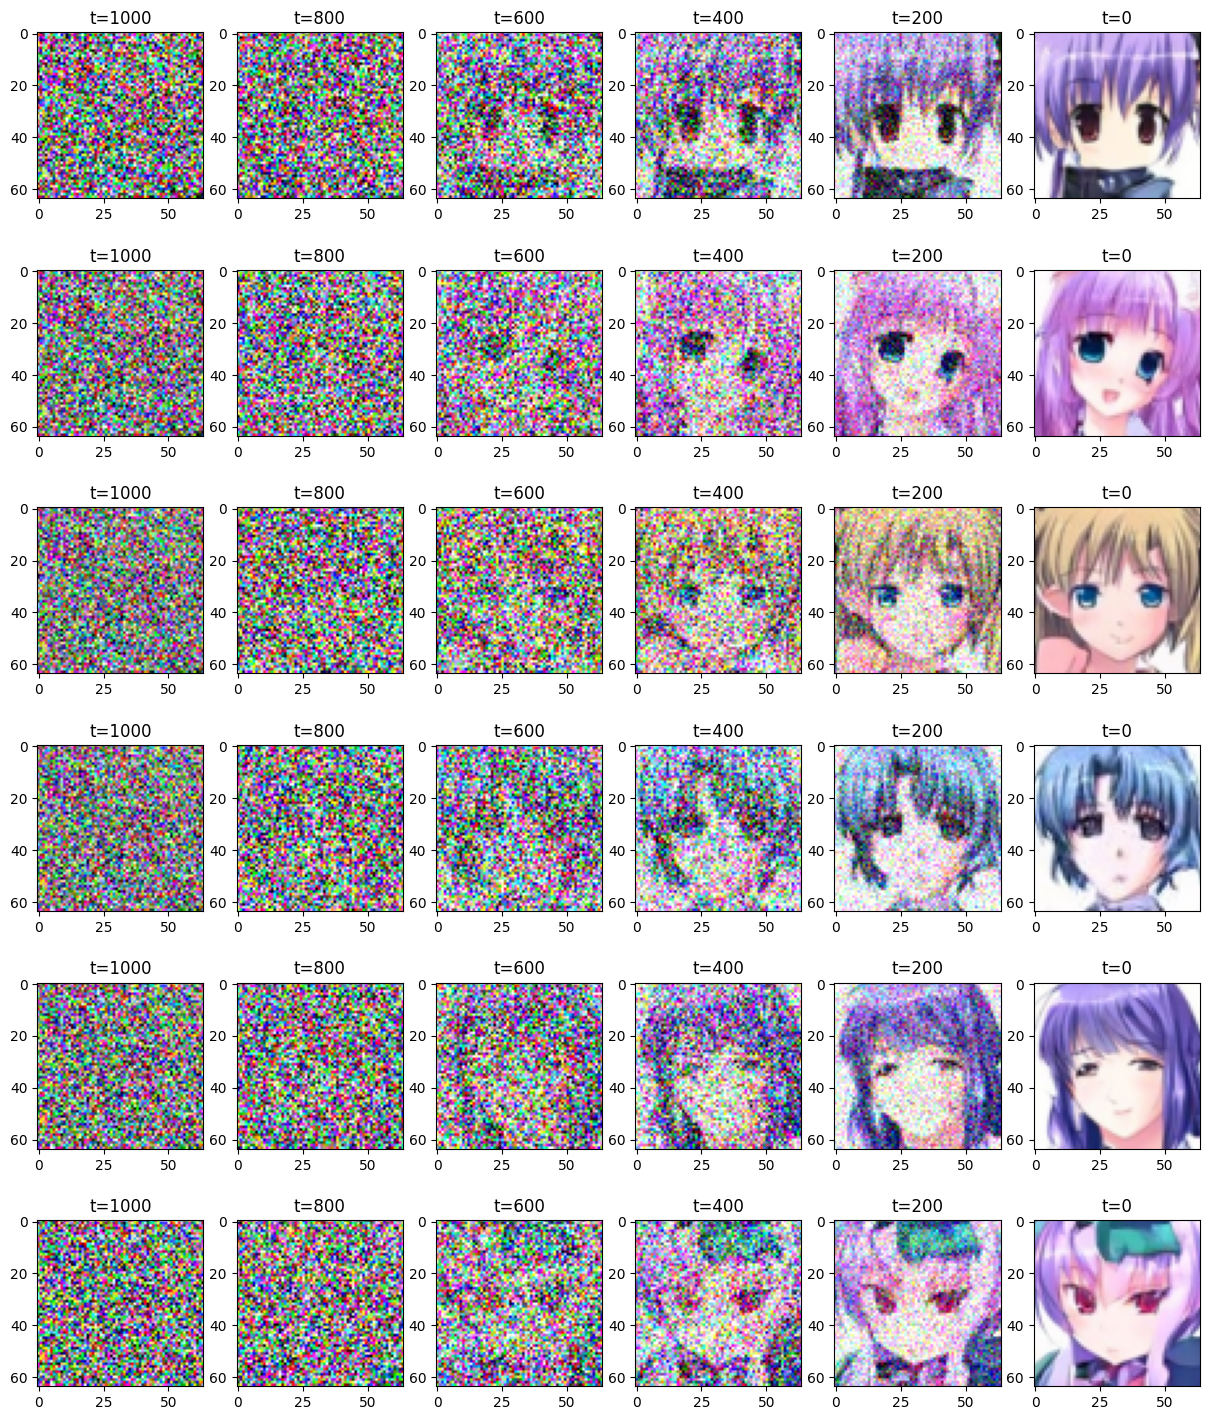

In [28]:
# Can't do that with DDPMs, can we?
from train.vis_utils import visualize_DDPM_denoising
interpolated_samples = visualize_DDPM_denoising(scheduler_dict, model, (3, 64, 64), forward_steps = 1000, steps_to_show = 5,
                         rows_to_show= len(interpolated_noises), device = device, noise = interpolated_noises)